# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Yke Rusticus"
NAME2 = "Christoph Hönes"
NAME3 = ""
EMAIL = "yke.rusticus@gmail.com"
EMAIL2 = "christoph.hoenes@gmail.com"
EMAIL3 = ""

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, September/October 2019

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [4]:
def gen_sine(n):
    x = np.arange(0,2*np.pi+1e-6,2*np.pi/(n-1))
    t = np.random.normal(sin(x),0.25)
    return x, t


In [5]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [6]:
def designmatrix(x, M): 
    Phi = np.ones([len(x),M+1])
    xes = np.transpose(np.broadcast_to(x,(M,len(x))))
    for j in range(M):
        Phi[:,j+1] = np.power(xes[:,j],j+1)
    return Phi

def fit_polynomial(x, t, M):
    Phi = designmatrix(x,M)
    w_ml = np.dot(np.linalg.pinv(Phi),t)
    return w_ml, Phi


In [7]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

In [8]:
def get_t_pred(x_pred, w, M):
    t_pred = np.zeros(len(x_pred))
    for i in range(M+1):
        t_pred += w[i]*np.power(x_pred,i)
    return t_pred

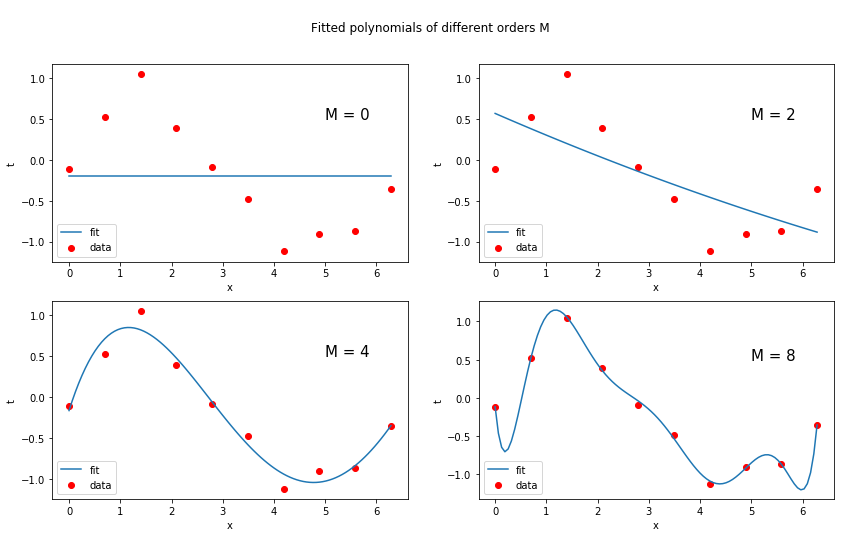

In [9]:
N = 10
x, t = gen_sine(N)
M = [0,2,4,8]
plt.figure(figsize=(14,8))
plt.suptitle("\nFitted polynomials of different orders M")
for m in M:
    w, Phi = fit_polynomial(x, t, m)
    x_pred = np.linspace(0,2*np.pi,100)
    t_pred = get_t_pred(x_pred, w, m)  
    plt.subplot(2,2,M.index(m)+1)
    plt.text(5,.5,"M = {}".format(m),fontsize=15)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.scatter(x,t,c='r',label="data")
    plt.plot(x_pred,t_pred,label="fit")
    plt.legend(loc="lower left")

plt.show()

### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [10]:
def fit_polynomial_reg(x, t, m, lamb):
    Phi = designmatrix(x,m)
    w_ml = np.dot(np.matmul(np.linalg.inv(lamb*np.identity(m+1) + np.matmul(Phi.transpose(),Phi)),Phi.transpose()),t)
    
    return w_ml, Phi


In [11]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



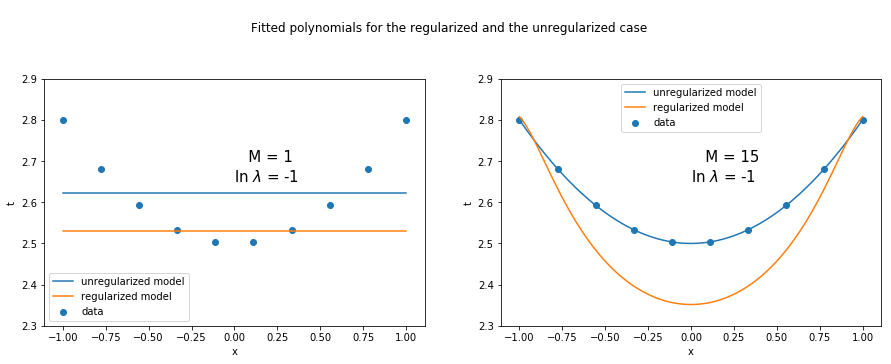

In [12]:
lnLamb = -1
N = 10
x = np.arange(-1,1+1e-6,2/(N-1))
t = 0.3 * np.power(x,2) + 2.5
M = [1,15]
Lmb = exp(lnLamb)
plt.figure(figsize=(15,10))
plt.suptitle("\nFitted polynomials for the regularized and the unregularized case")
for m in M:  
    w, Phi = fit_polynomial(x, t, m)
    w_reg, Phi_reg = fit_polynomial_reg(x, t, m, Lmb)    
    x_pred = np.linspace(-1,1,100)
    t_pred = get_t_pred(x_pred, w, m)
    t_pred_reg = get_t_pred(x_pred, w_reg, m)       
    plt.subplot(2,2,M.index(m)+1)
    plt.text(0.,2.7,"   M = {}".format(m),fontsize=15)
    plt.text(0.,2.65,"ln $\lambda$ = {}".format(lnLamb),fontsize=15)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.ylim(2.3,2.9)
    plt.scatter(x,t,label="data")
    plt.plot(x_pred,t_pred,label="unregularized model")
    plt.plot(x_pred,t_pred_reg,label="regularized model")
    plt.legend()
plt.show()

In [13]:
if np.sum(Phi == Phi_reg) == np.sum(np.ones(size(Phi))):
    print("Phi has not changed.")
else:
    print("Phi has changed.")
print("\nMagnitude of vector w before and after regularization for M = {}:".format(M[-1]))
print("   ||w|| = {} --> {}".format(round(np.sqrt(np.sum(np.power(w,2))),2),round(np.sqrt(np.sum(np.power(w_reg,2))),2)))

Phi has not changed.

Magnitude of vector w before and after regularization for M = 15:
   ||w|| = 2.52 --> 2.39


b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

Matrix $\bPhi$ does not change after introducing the regularization term, since it only depends on $\bx$ and M, not on $\bw$. However, $\bw$ does change because in the regularized case, the error function depends on $\bw$. We want to minimalize the error function, so the regularization term puts large penalties on large values for $\bw$. This results in lower $\bw$ values in the regularized case, compared to the non-regularized case. $\lambda$ is used to tune the amount of regularization, so for higher $\lambda$ the regularization term has more impact.
The simple test case with $t = 0.3*x^2 + 2.5$ is shown above.






### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [14]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    w, Phi= fit_polynomial_reg(x_train,t_train,M,reg)
    t_pred = get_t_pred(x_valid, w, M)
    pred_err = np.mean((t_pred - t_valid)**2)

    return pred_err


In [15]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [16]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [17]:
def find_best_m_and_lamb(x, t):
    train_folds, valid_folds = kfold_indices(10,5)
    M = np.arange(11,dtype=int)
    lamb = np.exp(-M)
    performance = np.zeros((len(M),len(lamb)))
    for m in range(len(M)):
        for l in range(len(lamb)):
            err = 0
            for k in range(5):
                err += pred_error(x[train_folds[k]],x[valid_folds[k]],t[train_folds[k]],t[valid_folds[k]],M[m],lamb[l])
                performance[m,l] = err/5
    best_combo = np.argwhere(performance == np.min(performance))
    print('best error is: ',np.min(performance))

    M_best = M[best_combo[0,0]]
    lamb_best = lamb[best_combo[0,1]]
    
    return M_best, lamb_best


In [18]:
### This is not an empty cell (You don't need to care about it).

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

We have to consider all possible combinations of hyperparameters because the hyperparameters are not always independent and might affect each other. E.g. optimizing one parameter, say M for a fixed $\lambda$, might not be the optimal result for a different $\lambda$.

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

Markov Chain Monte Carlo could be used as an alternative to explore the parameter space. By letting so called "walkers" wonder around randomly within a given interval for each parameter, the algorithm gradually converges towards the best combination of each of the parameters without trying all combinations.

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

best error is:  0.0476483557677
model with best error shown below


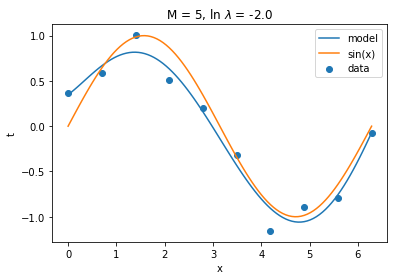

In [19]:
x, t = gen_sine(10)
M, lamb = find_best_m_and_lamb(x,t)
print("model with best error shown below")

w, _ = fit_polynomial_reg(x,t,M,lamb)
x_model = np.linspace(0,2*np.pi,100)
t_model = get_t_pred(x_model,w,M)

plt.figure()
plt.title('M = {}, ln $\lambda$ = {}'.format(M,np.log(lamb)))
plt.scatter(x,t, label='data')
plt.plot(x_model,t_model, label='model')
plt.plot(x_model,sin(x_model), label='sin(x)')
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [20]:
def gen_sine2(n):
    x = np.random.uniform(0,2*np.pi,n)
    t = np.random.normal(sin(x),0.25)
    
    return x, t


In [21]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [22]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    Phi = designmatrix(x,M)
    S = np.linalg.inv(alpha*np.identity(M+1) + beta*np.matmul(Phi.transpose(),Phi))
    m = beta*np.matmul(np.matmul(S,Phi.transpose()),t)
    return m, S, Phi


In [23]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [24]:
def predict_polynomial_bayes(x, m, S, beta):
    Phi = designmatrix(x,len(m)-1)
    sigma = np.zeros(len(x))
    for n in range(len(x)):
        sigma[n] = np.sqrt(1/beta + np.matmul(np.matmul(Phi[n].transpose(),S),Phi[n]))
    mean = np.zeros(len(sigma))
    for n in range(len(sigma)):
        mean[n] = np.matmul(m.transpose(),Phi[n])
    
    
    return mean, sigma, Phi


In [25]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


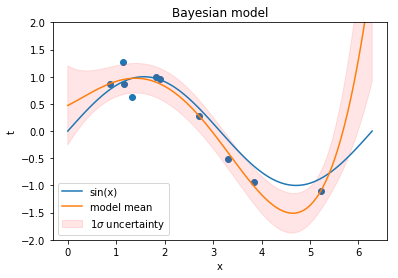

In [26]:
x, t = gen_sine2(10)
M = 4
alpha = 2/5
beta = 1/0.25**2
m, S, _ = fit_polynomial_bayes(x, t, M, alpha, beta)
x_plot = np.linspace(0,2*np.pi,100)
mean, sigma, _ = predict_polynomial_bayes(x_plot, m, S, beta)

plt.figure()
plt.scatter(x,t)
plt.plot(x_plot,np.sin(x_plot),label="sin(x)")
plt.plot(x_plot,mean,label="model mean")
plt.ylim(-2,2)
plt.title("Bayesian model")
plt.xlabel("x")
plt.ylabel("t")
plt.fill_between(x_plot,mean+sigma, mean-sigma, color='red', alpha=0.1, label="1$\sigma$ uncertainty")
plt.legend()
plt.show()

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


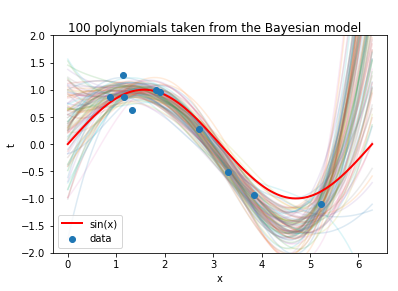

In [27]:
plt.figure()
plt.suptitle("\n100 polynomials taken from the Bayesian model")
for k in range(100):
    w = np.random.multivariate_normal(m,S)
    y = get_t_pred(x_plot, w, M)
    plt.plot(x_plot,y, alpha=0.15)
plt.scatter(x,t, label='data',zorder=100)
plt.plot(x_plot,sin(x_plot),color='red', linewidth=2,label='sin(x)')
plt.ylim(-2,2)
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



$\beta$ is given by $\beta = 1/\sigma^2$ and we chose $\sigma = 0.25$, so fitting with $\beta = \frac{1}{0.25^2}=16$ obviously gives the best result. We can only do this if we know beforehand that $\sigma = 0.25$, otherwise we would have to find the best estimate of $\beta$ using the given data.

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

For higher dimensional input, the number of basis functions needed increases rapidly, and most of the times exponentially [Bishop p.173]. Also, in the non-Bayesian approach, the complexity of the model strongly depends on the number of basis function. Choosing a too complex model (i.e. too many basisfunctions) could result in overfitting of the data. A too "simple" model could result in underfitting. And lastly, the performance of the model is dependend on the kind of basis functions we choose. However, it is not clear from the start which basis function will work best for your model.